This notebook has been adapated from a Data Science Group Tutorial created to explore the 311 call data.  It's using the call data from 2020.  We're trying to figure out why there are 172459 observations where ServiceDate is earlier than the CreateDate.  

Beginning with a dataset where rows with null dates were deleted, 73014 rows were deleted because ServiceDate is larger than 8/11/2022 and date columns were converted to datetime format

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')


In [2]:
pd.options.display.max_columns = None

In [23]:
pd.options.display.max_rows = None

<font size=5, color=green>Investigate on all the date columns<font>

<font size=3 color=gray>First of all we need to convert the type from object to date and then check to make sure there is not any date greater than today's date, then we can investigate for these criterias:<br>1. createddate <= servicedate<br>2. servicedate <= closeddate<br>3. closeddate <= updateddate<br>but we want to keep NaN value for these date columns<font>

In [3]:
#Import new data set with
#rows with null dates were deleted
#rows with ServiceDate larger than date retrieved were deleted
#date columns were converted to datetime format
#set the low_memory = False
df311_2020 = pd.read_csv(r'C:\Documents\projects\HackLA\311\data\MyLA311_Service_Request_Data_2020DT.csv', low_memory = False, index_col = 0)

In [4]:
df311_2020.shape

(1417538, 34)

In [5]:
df311_2020.head(2)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct
0,1-1523593381,2020-01-01 00:00:00,2020-01-07 12:19:00,SR Created,BOS,Illegal Dumping Pickup,Closed,Call,BOS,NaN,N,SLA,2020-01-07 00:00:00,2020-01-07 10:49:00,Y,N,"1500 W SLAUSON AVE, 90047",1500.0,W,SLAUSON,AVE,90047.0,33.988984,-118.302681,"(33.988984265, -118.302681205)",673.0,J,5.0,South Los Angeles APC,8.0,Marqueece Harris-Dawson,81.0,EMPOWERMENT CONGRESS CENTRAL AREA NDC,77TH STREET
1,1-1523590121,2020-01-01 00:00:00,2020-01-02 08:43:00,SR Created,BOS,Illegal Dumping Pickup,Closed,Call,BOS,NaN,N,WV,2020-01-02 00:00:00,2020-01-02 08:43:00,Y,N,"16815 W VANOWEN ST, 91406",16815.0,W,VANOWEN,ST,91406.0,34.194028,-118.499472,"(34.1940284578, -118.499471638)",531.0,D,6.0,South Valley APC,6.0,Nury Martinez,19.0,LAKE BALBOA NC,WEST VALLEY


In [12]:
#example when ServiceDate is later than create date 
df311_2020[df311_2020.CreatedDate > df311_2020.ServiceDate].head(2)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct
391,1-1523650478,2020-01-01 00:00:00,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2639 S ROBERTSON BLVD, 90034",NaN,S,NaN,BLVD,90034.0,34.037710,-118.388823,"(34.0377097705, -118.388822492)",632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES
392,1-1523650486,2020-01-01 00:00:00,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2743 S BEVERLY DR, 90034",NaN,S,NaN,DR,90034.0,34.037139,-118.396595,"(34.0371389447, -118.396594635)",632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES


In [6]:
#create dataframe of rows where CreatedDate is larger than ServiceDate
dfCD_SD = df311_2020[df311_2020.CreatedDate > df311_2020.ServiceDate]

In [7]:
dfCD_SD.shape

(172459, 34)

Out of 1417538 observations, 172459 rows where CreatedDated is larger than ServiceDate

In [8]:
dfCD_SD['RequestType'].unique()

array(['Graffiti Removal', 'Single Streetlight Issue',
       'Multiple Streetlight Issue'], dtype=object)

They are made up of RequestType of Graffiti and streetlight issues

In [9]:
dfCD_SD['RequestType'].value_counts()

Graffiti Removal              172382
Single Streetlight Issue          45
Multiple Streetlight Issue        32
Name: RequestType, dtype: int64

They are largely Graffiti Removal

In [10]:
#This is the dataframe containing only records with ServiceDate < Created Date
dfCD_SD.head(2)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct
391,1-1523650478,2020-01-01 00:00:00,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2639 S ROBERTSON BLVD, 90034",NaN,S,NaN,BLVD,90034.0,34.037710,-118.388823,"(34.0377097705, -118.388822492)",632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES
392,1-1523650486,2020-01-01 00:00:00,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2743 S BEVERLY DR, 90034",NaN,S,NaN,DR,90034.0,34.037139,-118.396595,"(34.0371389447, -118.396594635)",632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES


### In the data frame made up just of rows where 'CreatedDated' > 'Servicedate' - Explore each column looking for patterns

#### Explore distribution of 'CreatedDate' throughout the year

In [39]:
dfCD_SD['CreatedDate'].min()

'2020-01-01 00:00:00'

In [40]:
dfCD_SD['CreatedDate'].max()

'2020-12-31 00:00:00'

The 'CreatedDated' runs throughout the year

In [42]:
dfCD_SD['CreatedDate'].describe()

count                  172459
unique                    353
top       2020-05-13 00:00:00
freq                     1452
Name: CreatedDate, dtype: object

In [17]:
dfCD_SD["CreatedDate"] = dfCD_SD["CreatedDate"].astype("datetime64")

In [28]:
dfCD_SD['CreatedDate'].value_counts().head()

2020-05-13    1452
2020-01-02    1391
2020-04-24    1371
2020-02-19    1356
2020-09-22    1301
Name: CreatedDate, dtype: int64

In [29]:
dfCD_SD['CreatedDate'].value_counts().sort_index().head()

2020-01-01     201
2020-01-02    1391
2020-01-03     344
2020-01-04     317
2020-01-05     236
Name: CreatedDate, dtype: int64

In [30]:
dfCD_SD.head(2)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct
391,1-1523650478,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2639 S ROBERTSON BLVD, 90034",NaN,S,NaN,BLVD,90034.0,34.037710,-118.388823,"(34.0377097705, -118.388822492)",632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES
392,1-1523650486,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2743 S BEVERLY DR, 90034",NaN,S,NaN,DR,90034.0,34.037139,-118.396595,"(34.0371389447, -118.396594635)",632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES


In [41]:
#Create a new 'CreatedDateMonth' column which contains the number of the month from 'CreatedDate' 
#so can group on it and do functions by month
dfCD_SD['CreatedDateMonth'] = dfCD_SD['CreatedDate'].dt.month

In [33]:
dfCD_SD.head(2)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct,CreatedDateMonth
391,1-1523650478,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2639 S ROBERTSON BLVD, 90034",NaN,S,NaN,BLVD,90034.0,34.037710,-118.388823,"(34.0377097705, -118.388822492)",632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1
392,1-1523650486,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2743 S BEVERLY DR, 90034",NaN,S,NaN,DR,90034.0,34.037139,-118.396595,"(34.0371389447, -118.396594635)",632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1


#### Create a 'CreatedDateMonth' column so can do 'CreatedDate' functions by month

In [37]:
dfCD_SD.groupby('CreatedDateMonth').count()

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct
CreatedDateMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17006,17006,17006,17006,17006,17006,17006,17006,17006,17,17006,17006,17006,17006,17006,34,17006,28,16254,28,15768,17006,17006,17006,17006,17006,17006,17006,17006,17006,41,16954,16954,17006
2,12349,12349,12349,12349,12349,12349,12349,12349,12349,6,12349,12348,12349,12349,12349,21,12349,18,11617,18,11329,12349,12349,12349,12349,12349,12349,12349,12349,12349,23,12315,12315,12349
3,11696,11696,11696,11696,11696,11696,11696,11696,11696,10,11696,11696,11696,11696,11696,26,11696,19,10394,19,10153,11696,11696,11696,11696,11696,11696,11696,11696,11696,26,11667,11667,11696
4,12576,12576,12576,12576,12576,12576,12576,12576,12576,14,12576,12576,12576,12576,12576,21,12576,18,12098,18,11822,12575,12576,12576,12576,12576,12576,12576,12575,12576,22,12555,12555,12575
5,17343,17343,17343,17343,17343,17343,17343,17343,17343,13,17343,17343,17343,17343,17343,18,17343,19,16520,19,15952,17343,17343,17343,17343,17343,17343,17343,17343,17343,20,17322,17322,17343
6,15606,15606,15606,15606,15606,15606,15606,15606,15606,7,15606,15606,15606,15606,15606,19,15606,18,14738,18,13962,15606,15606,15606,15606,15606,15606,15606,15606,15606,20,15566,15566,15606
7,13638,13638,13638,13638,13638,13638,13638,13638,13638,8,13638,13638,13638,13638,13638,21,13638,17,12289,17,12085,13638,13638,13638,13638,13638,13638,13638,13638,13638,21,13601,13601,13638
8,12987,12987,12987,12987,12987,12987,12987,12987,12987,10,12987,12987,12987,12987,12987,20,12987,22,11767,22,11549,12987,12987,12987,12987,12987,12987,12987,12987,12987,22,12925,12925,12987
9,12521,12521,12521,12521,12521,12521,12521,12521,12521,4,12521,12521,12521,12521,12521,14,12521,12,11699,12,11256,12521,12521,12521,12521,12521,12521,12521,12521,12521,15,12483,12483,12521


(array([19163., 16730., 10879., 21585., 18719., 15238., 15259., 17037.,
        20708., 17141.]),
 array([18262. , 18298.5, 18335. , 18371.5, 18408. , 18444.5, 18481. ,
        18517.5, 18554. , 18590.5, 18627. ]),
 <BarContainer object of 10 artists>)

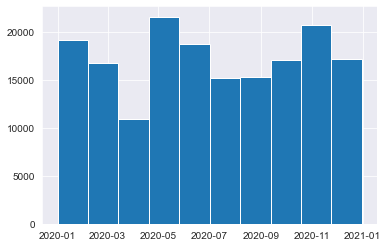

In [38]:
plt.hist(dfCD_SD['CreatedDate'])

### In the data frame made up just of rows where 'CreatedDated' > 'Servicedate' - 'CreatedDate is distributed pretty evenly with a high in May and a low in March

In [39]:
dfCD_SD.head(2)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct,CreatedDateMonth
391,1-1523650478,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2639 S ROBERTSON BLVD, 90034",NaN,S,NaN,BLVD,90034.0,34.037710,-118.388823,"(34.0377097705, -118.388822492)",632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1
392,1-1523650486,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2743 S BEVERLY DR, 90034",NaN,S,NaN,DR,90034.0,34.037139,-118.396595,"(34.0371389447, -118.396594635)",632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1


In [43]:
# to me - delete columns that probably won't matter when trying to figure out this question.  
# Then move the CreatedDateMonth next to createdDate, because I'll have to do one for each Date row.
# Remember to keep saving the data file
#figure out whatever aspects show something in this subset dataframe that where createddate > service date
#like value count of owner, request type, request source - then can ask for suggestions on who to contact
#also, compare to other years if have time

In [44]:
dfCD_SD.to_csv(r'C:\Documents\projects\HackLA\311\data\MyLA311_Service_Request_Data_2020DT.csv')

In [54]:
dfCD_SD = pd.read_csv(r'C:\Documents\projects\HackLA\311\data\MyLA311_Service_Request_Data_2020DT.csv', low_memory = False, index_col = 0)

In [55]:
dfCD_SD.head(2)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,ApproximateAddress,Address,HouseNumber,Direction,StreetName,Suffix,ZipCode,Latitude,Longitude,Location,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct,CreatedDateMonth
391,1-1523650478,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2639 S ROBERTSON BLVD, 90034",NaN,S,NaN,BLVD,90034.0,34.037710,-118.388823,"(34.0377097705, -118.388822492)",632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1
392,1-1523650486,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,NaN,"2743 S BEVERLY DR, 90034",NaN,S,NaN,DR,90034.0,34.037139,-118.396595,"(34.0371389447, -118.396594635)",632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1


In [56]:
dfCD_SD.drop(['SRNumber', 'ApproximateAddress', 
                'HouseNumber', 'Direction',
                'StreetName', 'Suffix',
                 'Latitude', 'Longitude',
                 'Location'], axis=1, inplace=True)


In [57]:
dfCD_SD.head(2)

,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,Address,ZipCode,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct,CreatedDateMonth
391,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,"2639 S ROBERTSON BLVD, 90034",90034.0,632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1
392,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,"2743 S BEVERLY DR, 90034",90034.0,632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES,1


In [58]:
dfCD_SD.to_csv(r'C:\Documents\projects\HackLA\311\data\MyLA311_Service_Request_Data_2020DT.csv')

In [60]:
#change order of columns so CreatedDateMonth is first - easier to read
cols = dfCD_SD.columns.tolist()
cols


['CreatedDate',
 'UpdatedDate',
 'ActionTaken',
 'Owner',
 'RequestType',
 'Status',
 'RequestSource',
 'CreatedByUserOrganization',
 'MobileOS',
 'Anonymous',
 'AssignTo',
 'ServiceDate',
 'ClosedDate',
 'AddressVerified',
 'Address',
 'ZipCode',
 'TBMPage',
 'TBMColumn',
 'TBMRow',
 'APC',
 'CD',
 'CDMember',
 'NC',
 'NCName',
 'PolicePrecinct',
 'CreatedDateMonth']

In [61]:
cols = cols[-1:] + cols[:-1]
cols

['CreatedDateMonth',
 'CreatedDate',
 'UpdatedDate',
 'ActionTaken',
 'Owner',
 'RequestType',
 'Status',
 'RequestSource',
 'CreatedByUserOrganization',
 'MobileOS',
 'Anonymous',
 'AssignTo',
 'ServiceDate',
 'ClosedDate',
 'AddressVerified',
 'Address',
 'ZipCode',
 'TBMPage',
 'TBMColumn',
 'TBMRow',
 'APC',
 'CD',
 'CDMember',
 'NC',
 'NCName',
 'PolicePrecinct']

In [62]:
dfCD_SD = dfCD_SD[cols]

In [63]:
dfCD_SD.head(2)

,CreatedDateMonth,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,Address,ZipCode,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct
391,1,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,"2639 S ROBERTSON BLVD, 90034",90034.0,632.0,H,6.0,South Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES
392,1,2020-01-01,2020-01-01 11:30:00,SR Created,OCB,Graffiti Removal,Closed,Driver Self Report,OCB,NaN,N,PGS,2019-12-05 11:11:00,2020-01-01 11:30:00,Y,"2743 S BEVERLY DR, 90034",90034.0,632.0,G,6.0,West Los Angeles APC,5.0,NaN,61.0,SOUTH ROBERTSON NC,WEST LOS ANGELES


In [64]:
dfCD_SD.to_csv(r'C:\Documents\projects\HackLA\311\data\MyLA311_Service_Request_Data_2020DT.csv')

In [66]:
#Create a new 'UpdatedDateM' column which contains the number of the month from 'UpdatedDate' 
dfCD_SD["UpdatedDate"] = dfCD_SD["UpdatedDate"].astype("datetime64")
dfCD_SD['UpdatedDateM'] = dfCD_SD['UpdatedDate'].dt.month

In [68]:
dfCD_SD.groupby('CreatedDateMonth').count()

,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,Anonymous,AssignTo,ServiceDate,ClosedDate,AddressVerified,Address,ZipCode,TBMPage,TBMColumn,TBMRow,APC,CD,CDMember,NC,NCName,PolicePrecinct,UpdatedDateM
CreatedDateMonth,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17006,17006,17006,17006,17006,17006,17006,17006,17,17006,17006,17006,17006,17006,17006,17006,17006,17006,17006,17006,17006,41,16954,16954,17006,17006
2,12349,12349,12349,12349,12349,12349,12349,12349,6,12349,12348,12349,12349,12349,12349,12349,12349,12349,12349,12349,12349,23,12315,12315,12349,12349
3,11696,11696,11696,11696,11696,11696,11696,11696,10,11696,11696,11696,11696,11696,11696,11696,11696,11696,11696,11696,11696,26,11667,11667,11696,11696
4,12576,12576,12576,12576,12576,12576,12576,12576,14,12576,12576,12576,12576,12576,12576,12575,12576,12576,12576,12575,12576,22,12555,12555,12575,12576
5,17343,17343,17343,17343,17343,17343,17343,17343,13,17343,17343,17343,17343,17343,17343,17343,17343,17343,17343,17343,17343,20,17322,17322,17343,17343
6,15606,15606,15606,15606,15606,15606,15606,15606,7,15606,15606,15606,15606,15606,15606,15606,15606,15606,15606,15606,15606,20,15566,15566,15606,15606
7,13638,13638,13638,13638,13638,13638,13638,13638,8,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638,13638,21,13601,13601,13638,13638
8,12987,12987,12987,12987,12987,12987,12987,12987,10,12987,12987,12987,12987,12987,12987,12987,12987,12987,12987,12987,12987,22,12925,12925,12987,12987
9,12521,12521,12521,12521,12521,12521,12521,12521,4,12521,12521,12521,12521,12521,12521,12521,12521,12521,12521,12521,12521,15,12483,12483,12521,12521


(array([2.2771e+04, 1.8109e+04, 2.2916e+04, 2.2733e+04, 1.8899e+04,
        1.9402e+04, 2.4335e+04, 2.2571e+04, 7.2000e+02, 3.0000e+00]),
 array([18262.47916667, 18307.97920602, 18353.47924537, 18398.97928472,
        18444.47932407, 18489.97936343, 18535.47940278, 18580.97944213,
        18626.47948148, 18671.97952083, 18717.47956019]),
 <BarContainer object of 10 artists>)

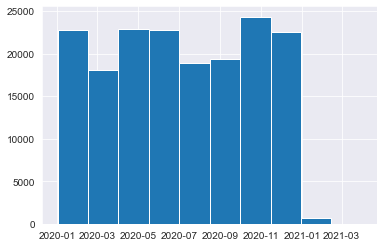

In [71]:
plt.hist(dfCD_SD['UpdatedDate'])

#### frequency of UpdatedDate fairly consistent through out the year.  Seems to drop off at beginning of next year but that's probably because the data is from 2020.  A next step is to see if the ServiceDate < CreatedDate pattern show up in other years

In [83]:
#Create a dataframe of just the dates to compare them
df_dates = dfCD_SD.filter(['CreatedDate','UpdatedDate','ServiceDate', 'ClosedDate'], axis=1)

In [74]:
df_dates.head()

,CreatedDate,UpdatedDate,ServiceDate,ClosedDate
391,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
392,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
393,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
394,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
395,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00


In [84]:
df_dates.dtypes

CreatedDate            object
UpdatedDate    datetime64[ns]
ServiceDate            object
ClosedDate             object
dtype: object

In [85]:
#Make sure they are all datetime64 type
df_dates = df_dates.astype({'CreatedDate': 'datetime64', 'ServiceDate': 'datetime64', 'ClosedDate': 'datetime64'})

In [86]:
df_dates.dtypes

CreatedDate    datetime64[ns]
UpdatedDate    datetime64[ns]
ServiceDate    datetime64[ns]
ClosedDate     datetime64[ns]
dtype: object

In [102]:
df_dates.head()

,CreatedDate,UpdatedDate,ServiceDate,ClosedDate
391,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
392,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
393,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
394,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00
395,2020-01-01,2020-01-01 11:30:00,2019-12-05 11:11:00,2020-01-01 11:30:00


<font size=5, color=green>Create timedelta columns<font>

<font size=3 color=gray>Now after cleaning up all the datetime columns, it's time to create timedelta columns:<br>1. to_service: difference between createddate and servicedate<br>2. to_close: difference between createddate and closeddate<br>3. to_update: difference between createddate and updateddate<font>

<font size=5, color=green>Investigate on zipcodes<font>

<font size=3 color=gray>First we need to check if there is any recorde with null value or alphabetic value, then compare it with LA zipcodes (ZIPCode.csv is available and contains all the legitimate zipcodes for LA).<font>

<font size=2 color=Navy>Check for null and remove if there is any<font>

<font size=2 color=Navy>Check for non-numeric records and remove if there is any<font>

<font size=2 color=Navy>Compare with legitimate zipcodes and remove non-legitimates<font>

In [ ]:
df_laZipcode = pd.read_csv('ZIPCode.csv')

<font size=5, color=green>Investigate on categorical fields<font>

<font size=3 color=gray>Select useful columns, explanation of each field is available here:<br>https://data.lacity.org/City-Infrastructure-Service-Requests/MyLA311-Service-Request-Data-2020/rq3b-xjk8<br> then investigate on each feature and fix if there is any issue<font>

In [ ]:
col = ['actiontaken', 'owner', 'requesttype', 'status', 'requestsource', 'createdbyuserorganization', 'mobileos', \
      'anonymous', 'assignto', 'addressverified', 'approximateaddress', 'apc', 'cd', 'cdmember', 'nc', 'ncname', \
      'policeprecinct']

In [ ]:
print('***actiontaken***')
print('-----------------')
print('Type is:')
print(df311.actiontaken.dtypes)
print('Null reacords:')
print(df311.actiontaken.isnull().sum())
print('Unique values:')
print(df311.actiontaken.unique())

<font size=2 color=Navy>Remove null records in this field<font>

In [ ]:
df311 = df311[df311.assignto.notnull()]

In [ ]:
print('***addressverified***')
print('---------------------')
print('Type is:')
print(df311.addressverified.dtypes)
print('Null reacords:')
print(df311.addressverified.isnull().sum())
print('Unique values:')
print(df311.addressverified.unique())

<font size=2 color=Navy>There won't be any report / dashboard based on this field, so we can keep it will all null values<font>

<font size=2 color=Navy>Remove null records in this field<font>

<font size=2 color=Navy>Remove null records in this field and then change the type to int64<font>

<font size=2 color=Navy>Remove null records in this field<font>

<font size=2 color=Navy>There are many records which has both nc and ncmember with null value, remove all of them<font>

<font size=2 color=Navy>Now cleaning up the ncname column<font>

<font size=5, color=green>Save the clean data set to a csv file<font>

# Now that you have gotten a quick overview of this dataset, you can begin exploring it on your own!

In [ ]:
print('Done!')